In [272]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [273]:
dataset = pd.read_csv('daily_sequential_pipe_failure_dataset.csv')
dataset.head()

,Data_pomiaru,ID_odcinka,Długość_odcinka,Materiał,Wiek_rury,Średnica,Ciśnienie,Przepływ,Temperatura_wody,pH_wody,...,Zawartość_chloru,Głębokość_ułożenia,Rodzaj_gruntu,Poziom_wód_gruntowych,Osiadanie_terenu,Data_ostatniej_awarii,Liczba_awarii,Kategoria_ruchu,Napięcie_katodowe,Data_prawdziwej_awarii
0,1951-01-01,1001,280,Beton,67,437,5.99,158,14.27,7.53,...,0.90,1.98,Gleba ilasta,2.79,0.16,2021-02-07,3,Średni,1.21,NaN
1,1951-01-02,1001,280,Beton,67,437,4.68,74,9.09,6.62,...,0.33,1.98,Gleba ilasta,2.79,0.07,2021-02-07,3,Średni,0.67,NaN
2,1951-01-03,1001,280,Beton,67,437,5.43,96,11.09,7.11,...,0.34,1.98,Gleba ilasta,2.79,0.18,2021-02-07,3,Lekki,0.92,NaN
3,1951-01-04,1001,280,Beton,67,437,3.33,60,6.00,8.40,...,0.82,1.98,Gleba ilasta,2.79,0.19,2021-02-07,3,Lekki,1.21,NaN
4,1951-01-05,1001,280,Beton,67,437,2.35,180,11.74,7.71,...,0.99,1.98,Gleba ilasta,2.79,0.09,2021-02-07,3,Lekki,1.12,NaN


In [274]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [275]:
base_date = datetime(1900, 1, 1)
date_columns = ['Data_pomiaru', 'Data_ostatniej_awarii', 'Data_prawdziwej_awarii']

for col in date_columns:
    dataset[col] = pd.to_datetime(dataset[col], errors='coerce')
    dataset[col] = dataset[col].apply(lambda x: (x - base_date).days if pd.notnull(x) else np.nan)

In [276]:
valid_indices = ~dataset['Data_prawdziwej_awarii'].isna()
dataset = dataset.loc[valid_indices]

In [277]:
y = dataset['Data_prawdziwej_awarii'].values

In [278]:
X = dataset.drop(columns=['Data_prawdziwej_awarii'])

In [279]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [3, 13, 18])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [280]:
print(type(X))
print(X.dtype)


<class 'numpy.ndarray'>
float64


In [281]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [283]:
class FailurePredictionDataset(Dataset):
    def __init__(self, features, targets, seq_length=30):  # Adjusted seq_length
        self.features = features
        self.targets = targets
        self.seq_length = seq_length

    def __len__(self):
        return len(self.features) - self.seq_length

    def __getitem__(self, idx):
        return (
            self.features[idx : idx + self.seq_length],
            self.targets[idx + self.seq_length],
        )

# Create the dataset and DataLoader
seq_length = 30  # Adjusted sequence length
batch_size = 64
dataset = FailurePredictionDataset(X, y, seq_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [284]:
class LSTMFailurePredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMFailurePredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, 1)
        self.hidden_size = hidden_size

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = X.shape[1]
hidden_size = 128
num_layers = 3
model = LSTMFailurePredictor(input_size, hidden_size, num_layers).to(device)

In [285]:
criterion = nn.MSELoss()  # Funkcja kosztu do regresji
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    for i, (seq, target) in enumerate(dataloader):
        seq = seq.float().to(device)  # Przenosimy dane wejściowe na GPU
        target = target.float().view(-1, 1).to(device)  # Przenosimy cel na GPU

        # Forward pass
        outputs = model(seq)
        loss = criterion(outputs, target)

        # Kara za przewidywanie daty po faktycznej dacie awarii
        penalty_mask = (outputs > target)
        loss += penalty_mask.sum() * 0.1  # Dodanie kary

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/50], Loss: 142182592.0000
Epoch [2/50], Loss: 142181216.0000
Epoch [3/50], Loss: 142179776.0000
Epoch [4/50], Loss: 142178160.0000
Epoch [5/50], Loss: 142176144.0000
Epoch [6/50], Loss: 142173456.0000
Epoch [7/50], Loss: 142169440.0000
Epoch [8/50], Loss: 142164848.0000
Epoch [9/50], Loss: 142151984.0000
Epoch [10/50], Loss: 142137152.0000
Epoch [11/50], Loss: 142122448.0000
Epoch [12/50], Loss: 142108144.0000
Epoch [13/50], Loss: 142096688.0000
Epoch [14/50], Loss: 142090496.0000
Epoch [15/50], Loss: 142080096.0000
Epoch [16/50], Loss: 142071648.0000
Epoch [17/50], Loss: 142066128.0000
Epoch [18/50], Loss: 142058464.0000
Epoch [19/50], Loss: 142051408.0000
Epoch [20/50], Loss: 142044944.0000
Epoch [21/50], Loss: 142039168.0000
Epoch [22/50], Loss: 142032832.0000
Epoch [23/50], Loss: 142025760.0000
Epoch [24/50], Loss: 142020384.0000
Epoch [25/50], Loss: 142014400.0000
Epoch [26/50], Loss: 142010672.0000
Epoch [27/50], Loss: 142005712.0000
Epoch [28/50], Loss: 142001024.0000
E

In [286]:
def visualize_prediction_differences(model, dataset, num_samples=None):
    model.eval()
    differences = []

    total_samples = len(dataset) if num_samples is None else num_samples

    for i in range(total_samples):
        seq, true_date_num = dataset[i]
        
        # Konwersja danych wejściowych do tensora i przeniesienie na odpowiednie urządzenie
        seq = torch.tensor(seq, dtype=torch.float32).unsqueeze(0).to(device)
        true_date_num = float(true_date_num)
    
        with torch.no_grad():
            predicted_date_num = model(seq).item()
    
        # Obliczenie różnicy w dniach
        difference = predicted_date_num - true_date_num
        differences.append(difference)
    
    # Klasyfikacja różnic
    before_count = sum(1 for diff in differences if diff < 0)
    on_time_count = sum(1 for diff in differences if diff == 0)
    after_count = sum(1 for diff in differences if diff > 0)
    
    # Wykres słupkowy
    labels = ['Przed awarią', 'W dniu awarii', 'Po awarii']
    counts = [before_count, on_time_count, after_count]

    plt.figure(figsize=(8, 6))
    plt.bar(labels, counts, color=['green', 'blue', 'red'])
    plt.ylabel('Liczba predykcji')
    plt.title('Czas predykcji względem rzeczywistej daty awarii')
    plt.show()
    
    # Wyświetlenie liczby predykcji w każdej kategorii
    print(f"Predykcje przed rzeczywistą awarią: {before_count}")
    print(f"Predykcje w dniu rzeczywistej awarii: {on_time_count}")
    print(f"Predykcje po rzeczywistej awarii: {after_count}")


In [287]:
def list_predictions(model, dataset, num_samples=10, base_date=datetime(1900, 1, 1)):
    model.eval()  # Przełączenie modelu w tryb ewaluacji
    results = []

    for i in range(num_samples):
        seq, true_date_num = dataset[i]
        
        # Konwersja danych wejściowych do tensora i przeniesienie na odpowiednie urządzenie
        seq = torch.tensor(seq, dtype=torch.float32).unsqueeze(0).to(device)
        true_date_num = float(true_date_num)
    
        with torch.no_grad():
            predicted_date_num = model(seq).item()
    
        # Konwersja numerów na daty
        true_date = base_date + timedelta(days=true_date_num)
        predicted_date = base_date + timedelta(days=predicted_date_num)
    
        results.append({
            'Próbka': i + 1,
            'Rzeczywista data awarii': true_date,
            'Przewidywana data awarii': predicted_date
        })
    
    # Wyświetlenie wyników w prostej tabeli
    print("{:<10} {:<25} {:<25}".format('Próbka', 'Rzeczywista data awarii', 'Przewidywana data awarii'))
    for result in results:
        print("{:<10} {:<25} {:<25}".format(
            result['Próbka'],
            result['Rzeczywista data awarii'].strftime('%Y-%m-%d'),
            result['Przewidywana data awarii'].strftime('%Y-%m-%d')
        ))

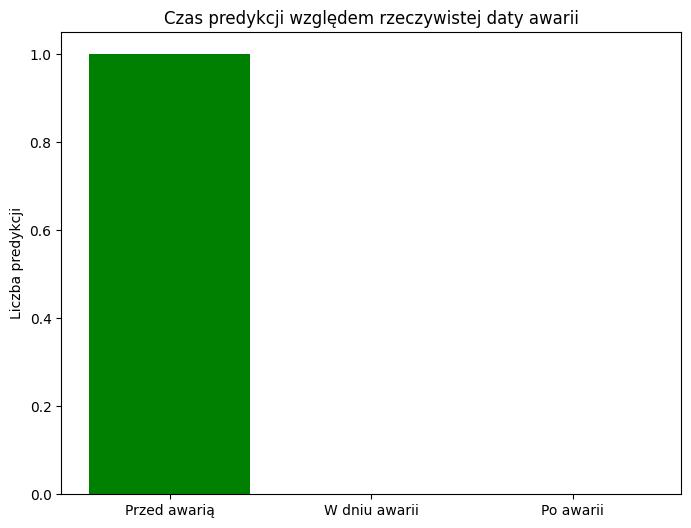

Predykcje przed rzeczywistą awarią: 1
Predykcje w dniu rzeczywistej awarii: 0
Predykcje po rzeczywistej awarii: 0


In [288]:
visualize_prediction_differences(model, dataset)

In [289]:
# Upewnij się, że 'model', 'dataset' i 'device' są zdefiniowane
list_predictions(model, dataset, num_samples=10)


IndexError: index 100 is out of bounds for axis 0 with size 100